In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
import torch, torchvision
import torch.nn as nn

In [2]:
datasetPath = "/home/flupec/datasets/{}/images/"
trainSubst = "WIDER_train"
testSubst = "WIDER_test"
validateSubst = "WIDER_val"

trainPath = datasetPath.format(trainSubst)
testPath = datasetPath.format(testSubst)
validatePath = datasetPath.format(validateSubst)

labelPath = "/home/flupec/datasets/wider_face_split/{}"
trainSubst = "wider_face_train_bbx_gt.txt"
validateSubst = "wider_face_val_bbx_gt.txt"

labelTrainPath = labelPath.format(trainSubst)
labelValidatePath = labelPath.format(validateSubst)

class LabeledImage:
    def __init__(self, relativeImgPath, absPath, bboxes):
        self.relativePath = relativeImgPath
        self.absPath = absPath
        self.bboxes = bboxes
        self.bboxesInterpolated = False
    
    def loadCvImage(self):
        img = cv.imread(self.absPath)
        
        if not self.bboxesInterpolated:
            newbboxes = []
            for bbox in self.bboxes:
                x, y, w, h = bbox
                x, y, w, h = int(x), int(y), int(w), int(h)

                x2 = x + w
                y2 = y + h

                newx = x / img.shape[1] * IMSIZE
                newy = y / img.shape[0] * IMSIZE

                newx2 = x2 / img.shape[1] * IMSIZE
                newy2 = y2 / img.shape[0] * IMSIZE

                neww = newx2 - newx
                newh = newy2 - newy

                newbboxes.append([int(newx), int(newy), int(neww), int(newh)])
            self.bboxes = newbboxes
            self.bboxesInterpolated = True
        
        img = cv.resize(img, dsize=[IMSIZE, IMSIZE], interpolation=cv.INTER_LINEAR)
        
        img = img.swapaxes(0, 2)
        return img
    
    def generateValidAnchors(self)->np.array:
        img = self.loadCvImage()
        centersX = np.arange(0, IMSIZE, GRID_CELL_SIZE)
        centersY = np.arange(0, IMSIZE, GRID_CELL_SIZE)
        anchors = []
        for centerY in centersY:
            for centerX in centersX:
                for ratio in ratios:
                    for scale in scales:
                        h = GRID_CELL_SIZE * scale * ratio
                        w = GRID_CELL_SIZE * scale * 1 / ratio
                        h = min(IMSIZE - centerX, h)
                        w = min(IMSIZE - centerY, w)
                        anchors.append([centerX, centerY, w, h])
        return np.array(anchors)
    
    def generateIousVersusBbox(self, rois)->np.array:
        roisAmount, gtBoxAmount = rois.shape[0], len(self.bboxes)
        ious = np.zeros([roisAmount, gtBoxAmount])
        for i in range(roisAmount):
            roi = rois[i]
            for j in range(gtBoxAmount):
                iou = bb_intersection_over_union(roi, self.bboxes[j])
                ious[i, j] = iou
        return ious
    
    def getBboxesNumpy(self)->np.array:
        return np.array(self.bboxes).astype(np.int)
    
    def tensorFromCvImage(self)->torch.Tensor:
        image = self.loadCvImage()
        newImg = np.zeros([1, *image.shape])
        newImg[0] = image
        return torch.Tensor(newImg)
    
    def getImgWithGtForPlot(self)->np.array:
        img = self.loadCvImage()
        img = img.swapaxes(0,2)  
        for i, gt in enumerate(self.bboxes):
            x, y = int(gt[0]), int(gt[1])
            h, w = int(gt[3]), int(gt[2])
            x, y = max(0, x), max(0, y)
            h, w = min(h, IMSIZE), min(w, IMSIZE)
            cv.rectangle(img, [x, y], [x + w, y + h], [255, 0, 0], 2)
            cv.putText(img, "{}".format([x, y]), (x, y), cv.FONT_HERSHEY_SIMPLEX, 
                       0.5, (255, 0, 0), 1, cv.LINE_AA)
        return img
    
    def __str__(self):
        return "absPath={}, relativePath={}, bboxes={}".format(self.absPath, self.relativePath, self.bboxes)

def datasetsImagePaths(basePath)->[str]:
    paths = []
    for currdir, subdirs, _ in os.walk(trainPath):
        for d in subdirs:
            for _, _, files in os.walk(trainPath + "/" + d):
                for f in files:
                    foundPath = trainPath + d + "/" + f
                    paths.append(foundPath)
    return paths

def getBoundindBoxesForLabeledImages(fullImgPathes: [str], train: bool)->dict:
    imgPathes = {}
    absPathes = {}
    
    for p in fullImgPathes:
        splitpath = p.split("/")
        file = splitpath[-1]
        folder = splitpath[-2]
        labeledPath = folder + "/" + file
        imgPathes[labeledPath] = []
        absPathes[labeledPath] = p
    labelPath = labelTrainPath if train else labelValidatePath # TODO: Test set??
    lines = open(labelPath, "r").readlines()

    for l in range(len(lines)):
        labelFilePath = lines[l].split("\n")[0]
        if labelFilePath in imgPathes: # found corresponding image in imgPathes
            bboxAmount = int(lines[l + 1].split("\n")[0])
            for bboxIdx in range(bboxAmount):
                bboxLine = lines[l + 2 + bboxIdx].split("\n")[0]
                bboxLineSplit = bboxLine.split(" ")
                x, y, w, h = bboxLineSplit[0], bboxLineSplit[1], bboxLineSplit[2], bboxLineSplit[3]
                valid = int(bboxLineSplit[7])  == 0
                if valid:
                    imgPathes.get(labelFilePath, []).append((x, y, w, h))
                
    newImgPathes = {}
    for k in imgPathes:
        newImgPathes[k] = LabeledImage(k, absPathes[k], imgPathes[k])
    return newImgPathes

In [3]:
trainPathes = datasetsImagePaths(trainPath)
labeledImages = getBoundindBoxesForLabeledImages(trainPathes, True)

print(len(labeledImages))

# TODO: Load Validate set and maybe Test set?

assert len(trainPathes) == len(labeledImages)

12880


In [4]:
model = torchvision.models.vgg16(pretrained=True)
model = torch.nn.Sequential(*list(model.features)[0: -1])

(1, 512, 32, 32)


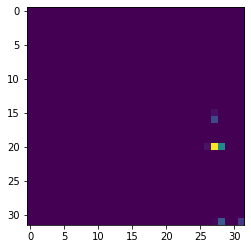

In [5]:
IMSIZE = 512
    
it = iter(labeledImages)
next(it)
next(it)
next(it)
randomLabeledImage = labeledImages[next(it)]
randomImageTensor = randomLabeledImage.tensorFromCvImage()

result = model.forward(randomImageTensor)
print(result.detach().numpy().shape)
plt.imshow(result.detach().numpy()[0][100])

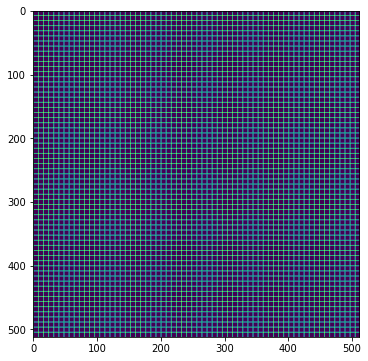

In [6]:
GRID_CELL_SIZE = 16

ratios = (0.5, 1, 2)
scales = (1, 4, 8, 16)

def visualizeAnchors(anchors):
    drawImg = np.zeros([512, 512])
    for i, anchor in enumerate(anchors):
        x, y = int(anchor[0]), int(anchor[1])
        w, h = int(anchor[2]), int(anchor[3])
        x, y = max(0, x), max(0, y)
        h, w = min(h, IMSIZE), min(w, IMSIZE)
        cv.rectangle(drawImg, [x, y], [x + w, y + h], [255, 255, 255], 1)

    plt.figure(figsize=[6,6])
    plt.imshow(drawImg)

visualizeAnchors(randomLabeledImage.generateValidAnchors())

In [7]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(float(boxA[0]), float(boxB[0]))
    yA = max(float(boxA[1]), float(boxB[1]))
    xB = min(float(boxA[2]) + float(boxA[0]), float(boxB[2]) + float(boxB[0]))
    yB = min(float(boxA[3]) + float(boxA[1]), float(boxB[3]) + float(boxB[1]))

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA + 1, 0)) * max((yB - yA + 1), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((int(boxA[2]) - int(boxA[0]) + 1) * (int(boxA[3]) - int(boxA[1]) + 1))
    boxBArea = abs((int(boxB[2]) - int(boxB[0]) + 1) * (int(boxB[3]) - int(boxB[1]) + 1))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [8]:
faceAmountKey = max(labeledImages, key=lambda k: len(labeledImages[k].bboxes))
MAX_FACE_AMOUNT = len(labeledImages[faceAmountKey].bboxes)

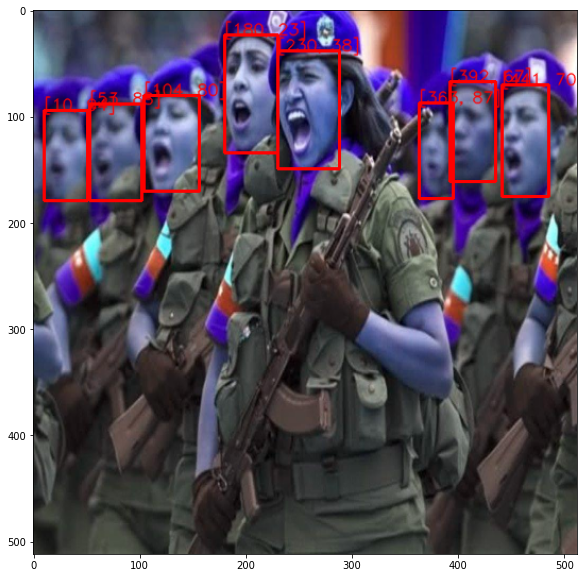

In [9]:
img = randomLabeledImage.getImgWithGtForPlot()
plt.figure(figsize=[10,10])
plt.imshow(img)

In [10]:
POSITIVE_LABEL_THRESHOLD = 0.7
NEGATIVE_LABEL_THRESHOLD = 0.3

POSITIVE_LABEL = 1
NEGATIVE_LABEL = 0
NOT_CONTRIBUTE_LABEL = -1

def getAnchorsGtsLocsLabels(labeledImage)->(np.array, np.array, np.array, np.array):
    """
        Возвращает якори, им соответствующие гт боксы с макс площадью
        пересечения и расстояния (locs) между якорем и гт боксом и метки
    """
    anchor = labeledImage.generateValidAnchors()
    ious = labeledImage.generateIousVersusBbox(anchor)
    maxIouIdx = np.argmax(ious, axis=1)

    bboxes = labeledImage.getBboxesNumpy()

    # Находим gt боксы для каждого якоря с максимальным IOU
    maxbboxes = []
    for i in range(ious.shape[0]):
        maxbboxes.append(bboxes[maxIouIdx[i]])

    maxGts = np.vstack(maxbboxes) # ГТ боксы для каждого якоря

    # Находим метки (labels)
    labels = np.zeros(anchor.shape[0], dtype=np.int32)
    labels = NOT_CONTRIBUTE_LABEL * labels # не учавствующие раввны -1
    for i in range(anchor.shape[0]):
        # Метка положительная если пересечение существенно
        if len(np.where(ious[i, :] >= POSITIVE_LABEL_THRESHOLD)[0]) > 0:
            labels[i] = POSITIVE_LABEL
    labels[np.argmax(ious, axis=0)] = POSITIVE_LABEL
    # Метка отрицательная если пересечение несущественно
    for i in range(len(labels)):
        denotedAsBackground = labels[i] == NOT_CONTRIBUTE_LABEL and np.all(ious[i, :] < NEGATIVE_LABEL_THRESHOLD)
        if denotedAsBackground:
            labels[i] = NEGATIVE_LABEL

    # Находим anchor locs
    locs = []
    for i in range(ious.shape[0]):
        xMidGt = (maxGts[i, 0] + maxGts[i, 2]) / 2
        yMidGt = (maxGts[i, 1] + maxGts[i, 3]) / 2
        xMidAnchor = (anchor[i, 0] + anchor[i, 2]) / 2
        yMidAnchor = (anchor[i, 1] + anchor[i, 3]) / 2
        tx = (xMidGt - xMidAnchor) / anchor[i, 2]
        ty = (yMidGt - yMidAnchor) / anchor[i, 3]
        th = np.log(maxGts[i, 3] / anchor[i, 3])
        tw = np.log(maxGts[i, 2] / anchor[i, 2])
        locs.append([tx, ty, tw, th])

    anchorLocs = np.vstack(locs)
    
    return anchor, maxGts, anchorLocs, labels

# test
anchors, maxGts, anchorLocs, labels = getAnchorsGtsLocsLabels(randomLabeledImage)
print(anchors.shape)
print(maxGts.shape)
print(anchorLocs.shape)
print(labels.shape)

(12288, 4)
(12288, 4)
(12288, 4)
(12288,)


In [11]:
anchorsNum = len(ratios) * len(scales)
conv1 = nn.Conv2d(IMSIZE, 512, 3, 1, 1)
regLayer = nn.Conv2d(512, anchorsNum * 4, 1, 1, 0)
clsLayer = nn.Conv2d(512, anchorsNum * 2, 1, 1, 0)

In [12]:
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
regLayer.weight.data.normal_(0, 0.01)
regLayer.bias.data.zero_()
clsLayer.weight.data.normal_(0, 0.01)
clsLayer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
# test to see shapes
x = conv1(result)
print(x.shape)
predAnchorLocs = regLayer(x)
predClsScores = clsLayer(x)

print(predAnchorLocs.shape)
print(predClsScores.shape)

objectnessScore = predClsScores.view(1, 24, 32, 16, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectnessScore.shape)

predAnchorLocs = predAnchorLocs.contiguous().view(1, -1, 4)
print(predAnchorLocs.shape)

predClsScores = predClsScores.contiguous().view(1, -1, 2)
print(predClsScores.shape)

assert predAnchorLocs.shape[1] == anchors.shape[0] == predClsScores.shape[1]

torch.Size([1, 512, 32, 32])
torch.Size([1, 48, 32, 32])
torch.Size([1, 24, 32, 32])
torch.Size([1, 12288])
torch.Size([1, 12288, 4])
torch.Size([1, 12288, 2])


In [14]:
def bboxFromPredicted(predLocs: torch.Tensor, anchors: np.array)->np.array:
    assert predLocs.shape[1] == anchors.shape[0]
    # [tx, ty, tw, th] is input for each predLocs
    # find [xc, yc, w, h] and then [x, y, w, h]
    predLocsNumpy = predLocs[0].data.numpy()
    
    predictedBboxes = []
    for i in range(anchors.shape[0]):
        hAnchor, wAnchor = anchors[i, 3], anchors[i, 2]
        
        xMidAnchor = (anchors[i, 0] + wAnchor) / 2
        yMidAnchor = (anchors[i, 1] + hAnchor) / 2
         
        tx, ty, tw, th = predLocsNumpy[i, :]
        
        xc = tx * wAnchor + xMidAnchor
        yc = ty * hAnchor + yMidAnchor
        
        h = np.exp(th) * hAnchor
        w = np.exp(tw) * wAnchor
        
        x = xc - w / 2
        y = yc - h / 2
        
        h = min(IMSIZE - y, h)
        w = min(IMSIZE - x, w)
        
        predictedBboxes.append([x, y, w, h])
    
    return np.vstack(predictedBboxes)

nmsThreshold = 0.7
bboxNumBeforeNmsTrain = 4000
bboxNumAfterNmsTrain = 800

bboxNumBeforeNmsTest = 2000
bboxNumAfterNmsTest = 400
roiMinSize = 16

In [15]:
# TODO: Чем отличается predScores от objectnessScores? Источник то у них один.
def roiProposalLayer(predLocs: torch.Tensor, predScores: torch.Tensor, objectnessScores: torch.Tensor, anchors: np.array,  train: bool):
    # Convert coordinates
    bboxPredLocs = bboxFromPredicted(predLocs, anchors)

    # Filter by width and height size and by x and y at fact that lies withit window
    notSmallIdx = np.where(
        (bboxPredLocs[:, 2] > roiMinSize) &
        (bboxPredLocs[:, 3] > roiMinSize) &
        (bboxPredLocs[:, 0] >= 0) &
        (bboxPredLocs[:, 0] < IMSIZE) &
        (bboxPredLocs[:, 1] >= 0) &
        (bboxPredLocs[:, 1] < IMSIZE)
    )[0]

    bboxPredLocs = bboxPredLocs[notSmallIdx]
    anchors = anchors[notSmallIdx]
    predScores = predScores.data.numpy()[0, notSmallIdx, :]
    objectnessScores = objectnessScores.data.numpy()[:, notSmallIdx]
    
    # Non maximum supression
    sortByScoreIdx = np.argsort(objectnessScores)[::-1]
    if train:
        sortByScoreIdx = sortByScoreIdx[:bboxNumBeforeNmsTrain]
    else:
        sortByScoreIdx = sortByScoreIdx[:bboxNumBeforeNmsTest]
    
    nmsResultIdxes = []
    good = [True for i in range(sortByScoreIdx.shape[1])]
    
    for i in range(sortByScoreIdx.shape[1] - 1):
        if not good[i]:
            continue    
        firstIdx = sortByScoreIdx[0, i]
        first = bboxPredLocs[firstIdx]
        nmsResultIdxes.append(firstIdx)
        
        for j in range(i + 1, sortByScoreIdx.shape[1]):
            secondIdx = sortByScoreIdx[0, j]
            second = bboxPredLocs[secondIdx]
            iou = bb_intersection_over_union(first, second)
            if iou > 0.7:
                good[j] = False
    nmsResultIdxes = np.array(nmsResultIdxes)
    if train:
        nmsResultIdxes = nmsResultIdxes[: bboxNumAfterNmsTrain]
    else:
        nmsResultIdxes = nmsResultIdxes[: bboxNumAfterNmsTest]
    
    # Got non maximum supressed ROI's
    bboxPredLocs = bboxPredLocs[nmsResultIdxes]
    anchors = anchors[nmsResultIdxes]
    predScores = predScores[nmsResultIdxes]
    objectnessScores = objectnessScores[:, nmsResultIdxes]
                
    return bboxPredLocs, predScores, objectnessScores, anchors

In [16]:
# Train
for imgPath in labeledImages:
    print(imgPath)
    labeledImage = labeledImages[imgPath]
    anchors, maxGts, anchorLocs, labels = getAnchorsGtsLocsLabels(labeledImage)
    tensorLabeledImage = labeledImage.tensorFromCvImage()
    
    afterBackbone = model.forward(tensorLabeledImage)
    x = conv1(afterBackbone)
    predAnchorLocs = regLayer(x)
    predClsScores = clsLayer(x)
    
    objectnessScore = predClsScores.view(1, 24, 32, 16, 2)[:, :, :, :, 1].contiguous().view(1, -1)
    predAnchorLocs = predAnchorLocs.contiguous().view(1, -1, 4)
    predClsScores = predClsScores.contiguous().view(1, -1, 2)
    assert predAnchorLocs.shape[1] == anchors.shape[0] == predClsScores.shape[1]
    
    roiProposals, predScores, objectnessScores, anchors = roiProposalLayer(predAnchorLocs, predClsScores, objectnessScore, anchors, True)
    
    print("From ROI proposal layer:")
    print("Roi proposals", roiProposals.shape)
    print("anchors", anchors.shape)
    print("labels", labels.shape)
    print("objectness scores", objectnessScores.shape)

0--Parade/0_Parade_marchingband_1_35.jpg
From ROI proposal layer:
Roi proposals (800, 4)
anchors (800, 4)
labels (12288,)
objectness scores (1, 800)
0--Parade/0_Parade_marchingband_1_295.jpg
From ROI proposal layer:
Roi proposals (800, 4)
anchors (800, 4)
labels (12288,)
objectness scores (1, 800)
0--Parade/0_Parade_marchingband_1_796.jpg
From ROI proposal layer:
Roi proposals (800, 4)
anchors (800, 4)
labels (12288,)
objectness scores (1, 800)
0--Parade/0_Parade_Parade_0_600.jpg
From ROI proposal layer:
Roi proposals (800, 4)
anchors (800, 4)
labels (12288,)
objectness scores (1, 800)
0--Parade/0_Parade_Parade_0_17.jpg
From ROI proposal layer:
Roi proposals (800, 4)
anchors (800, 4)
labels (12288,)
objectness scores (1, 800)
0--Parade/0_Parade_marchingband_1_1018.jpg
From ROI proposal layer:
Roi proposals (800, 4)
anchors (800, 4)
labels (12288,)
objectness scores (1, 800)
0--Parade/0_Parade_Parade_0_52.jpg
From ROI proposal layer:
Roi proposals (800, 4)
anchors (800, 4)
labels (12288

KeyboardInterrupt: 